<a href="https://colab.research.google.com/github/saurabh2086/tensorFlowInPractice/blob/master/S%2BP_Week_2_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install tensorflow==2.0.0-beta1


     |████████████████████████████████| 87.9MB 152kB/s 
     |████████████████████████████████| 3.1MB 38.6MB/s 
     |████████████████████████████████| 501kB 44.2MB/s 
ERROR: tf-nightly-2-0-preview 2.0.0.dev20190815 has requirement tb-nightly<1.16.0a0,>=1.15.0a0, but you'll have tb-nightly 1.14.0a20190603 which is incompatible.
  Found existing installation: tb-nightly 1.15.0a20190815
    Uninstalling tb-nightly-1.15.0a20190815:
      Successfully uninstalled tb-nightly-1.15.0a20190815
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.14.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  """just an arbitory pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
def seasonality(time, period, amplitude, phase=0):
  season_time = (time+phase) % period / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


In [0]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# create the series 
series = baseline \
+ trend(time, slope) \
+ seasonality(time, 365, amplitude=amplitude) \
+ noise(time, noise_level,seed=42)

In [0]:
# splitting into train and validation data
split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [53]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1,  input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights {}".format(l0.get_weights()))

<DatasetV1Adapter shapes: ((?, ?), (?,)), types: (tf.float64, tf.float64)>
Layer weights [array([[-0.03113041],
       [-0.0659961 ],
       [ 0.09246016],
       [-0.064275  ],
       [ 0.13355465],
       [-0.02740701],
       [-0.02766882],
       [-0.04426122],
       [ 0.10147452],
       [-0.04990144],
       [-0.0431586 ],
       [-0.04105799],
       [ 0.07622227],
       [ 0.06418439],
       [ 0.00889077],
       [-0.02568833],
       [ 0.03386908],
       [ 0.17025164],
       [ 0.3388566 ],
       [ 0.40829873]], dtype=float32), array([0.01868707], dtype=float32)]


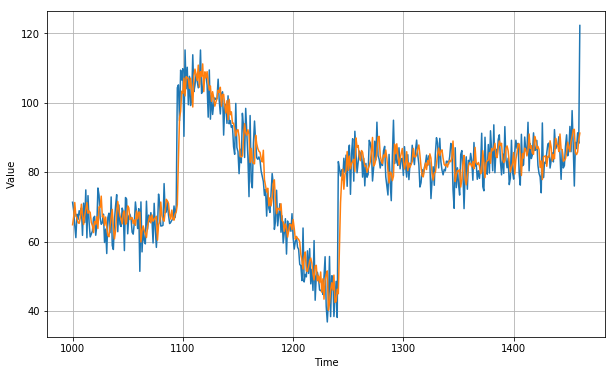

In [54]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [55]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, results)
mae.numpy()

SyntaxError: ignored